<a href="https://colab.research.google.com/github/ignc-research/industrial-web-application/blob/main/laser_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [76]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


# Helper Functions



In [77]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)



# Data Import & Data Preparation


In [78]:
from google.colab import drive

colab = True

if colab==True:
  drive.mount("/content/gdrive")
  path = '/content/gdrive/MyDrive/ias/naht'
  dir = os.listdir(path)
else:
  path = 'naht'
  dir = os.listdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
def to_np_array(vector_str):
    np_vector = np.array(vector_str.split())
    np_vector = np_vector.astype(np.float32)
    return np_vector

In [80]:
"""
path='/content/gdrive/MyDrive/ias/naht/201910204483.PgmDef_82_1.TAND_GERAD_DD.10.1.csv'
sample=True

raw_dataset = pd.read_csv(path, na_values='?', comment='\t', sep=';', skipinitialspace=True)
dataset = raw_dataset.copy()

if sample:
  dataset = dataset.iloc[::int(len(dataset) / (20-1)),:]

vector_cols = ('Punkt_Pos', 'Punkt_Fl_Norm1', 'Punkt_Fl_Norm2', 'Frame_Pos', 'Frame_Xvek', 'Frame_Yvek', 'Frame_Zvek', 'pos', 'nor_pos')
df_with_arrays = dataset.copy(deep=True)

for col in vector_cols:
  df_with_arrays[col] = df_with_arrays[col].apply(to_np_array)

point_data = df_with_arrays.copy(deep=True).iloc[1,:]
point_data['pos'] = df_with_arrays['pos'].to_numpy()
point_data['hit_fraction'] = df_with_arrays['hit_fraction'].to_numpy().astype(np.float32)

point_data['hit_fraction']
point_data = point_data.to_frame().T
"""

"\npath='/content/gdrive/MyDrive/ias/naht/201910204483.PgmDef_82_1.TAND_GERAD_DD.10.1.csv'\nsample=True\n\nraw_dataset = pd.read_csv(path, na_values='?', comment='\t', sep=';', skipinitialspace=True)\ndataset = raw_dataset.copy()\n\nif sample:\n  dataset = dataset.iloc[::int(len(dataset) / (20-1)),:]\n\nvector_cols = ('Punkt_Pos', 'Punkt_Fl_Norm1', 'Punkt_Fl_Norm2', 'Frame_Pos', 'Frame_Xvek', 'Frame_Yvek', 'Frame_Zvek', 'pos', 'nor_pos')\ndf_with_arrays = dataset.copy(deep=True)\n\nfor col in vector_cols:\n  df_with_arrays[col] = df_with_arrays[col].apply(to_np_array)\n\npoint_data = df_with_arrays.copy(deep=True).iloc[1,:]\npoint_data['pos'] = df_with_arrays['pos'].to_numpy()\npoint_data['hit_fraction'] = df_with_arrays['hit_fraction'].to_numpy().astype(np.float32)\n\npoint_data['hit_fraction']\npoint_data = point_data.to_frame().T\n"

In [81]:
def create_data(path, sample):
    raw_dataset = pd.read_csv(path, na_values='?', comment='\t', sep=';', skipinitialspace=True)
    dataset = raw_dataset.copy()

    if sample:
      #dataset = dataset.iloc[::int(len(dataset) / (20)),:]
      dataset = dataset.iloc[:20,:]
    vector_cols = ('Punkt_Pos', 'Punkt_Fl_Norm1', 'Punkt_Fl_Norm2', 'Frame_Pos', 'Frame_Xvek', 'Frame_Yvek', 'Frame_Zvek', 'pos', 'nor_pos')
    df_with_arrays = dataset.copy(deep=True)

    for col in vector_cols:
        df_with_arrays[col] = df_with_arrays[col].apply(to_np_array)

    point_data = df_with_arrays.copy(deep=True).iloc[1,:]
    point_data['pos'] = df_with_arrays['pos'].to_numpy()
    point_data['hit_fraction'] = df_with_arrays['hit_fraction'].to_numpy().astype(np.float32)

    point_data = point_data.to_frame().T
    return point_data

In [82]:
data = pd.DataFrame(columns=['WkzWkl',
                             'WkzName',
                             'Punkt_Pos',
                             'Punkt_Fl_Norm1',
                             'Punkt_Fl_Norm2',
                             'Frame_Pos',
                             'Frame_Xvek',
                             'Frame_Yvek',
                             'Frame_Zvek',
                             'hit_fraction',
                             'pos',
                             'nor_pos',
                             'csv_name'])

In [83]:
for file in dir:
  point_data = create_data('{}/{}'.format(path, file), True)
  point_data['csv_name'] = file
  data = pd.concat([data, point_data], ignore_index=True)
#data.sort_values(by=['csv_name'])

In [84]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

y_train = pd.concat([train_dataset.pop(col) for col in ['Frame_Xvek', 'Frame_Yvek', 'Frame_Zvek']], axis=1)
X_train = pd.concat([train_dataset.pop(col) for col in ['pos']], axis=1)

y_test = pd.concat([test_dataset.pop(col) for col in ['Frame_Xvek', 'Frame_Yvek', 'Frame_Zvek']], axis=1)
X_test = pd.concat([test_dataset.pop(col) for col in ['pos']], axis=1)

In [85]:
y_train = np.array([np.vstack(arr) for arr in np.array(y_train)])
X_train = np.array([np.vstack(arr[0]) for arr in np.array(X_train)])
y_test = np.array([np.vstack(arr) for arr in np.array(y_test)])
X_test = np.array([np.vstack(arr[0]) for arr in np.array(X_test)])

# Regression Model


In [86]:
def build_and_compile_model():


  dense = layers.Dense(64, activation="relu")

  inputs = keras.Input(shape=(20,3))
  x = dense(inputs)

  x = tf.keras.layers.UpSampling1D(3)(inputs)  

  x = tf.keras.layers.MaxPooling1D(20)(x)  
  x = layers.Dense(64, activation="relu")(x)
  x = layers.Dense(64, activation="relu")(x)

  outputs = layers.Dense(3)(x)


  model = keras.Model(inputs=inputs, outputs=outputs, name="model")
  """
  model = keras.Model([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(3)
  ])
  """
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])
  
  return model


dnn_model = build_and_compile_model()
dnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 up_sampling1d_7 (UpSampling  (None, 60, 3)            0         
 1D)                                                             
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 3, 3)             0         
 1D)                                                             
                                                                 
 dense_29 (Dense)            (None, 3, 64)             256       
                                                                 
 dense_30 (Dense)            (None, 3, 64)             4160      
                                                                 
 dense_31 (Dense)            (None, 3, 3)              195   

In [ ]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    validation_data=(X_test, y_test))


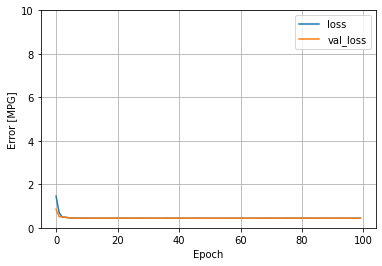

In [88]:
plot_loss(history)

In [91]:
print("Evaluate on test data")
results = dnn_model.evaluate(X_test, y_test, batch_size=128, verbose=2)
print("test loss, test acc:", results)

Evaluate on test data
1/1 - 0s - loss: 0.4465 - accuracy: 0.3333 - 27ms/epoch - 27ms/step
test loss, test acc: [0.4465126097202301, 0.3333333432674408]


In [90]:
dnn_model.predict(X_test[:1]), y_test[:1]



(array([[[-0.027, -0.006, -0.004],
         [-0.027, -0.006, -0.004],
         [-0.027, -0.006, -0.004]]], dtype=float32),
 array([[[ 0.977,  0.212,  0.   ],
         [-0.148,  0.683, -0.715],
         [-0.151,  0.699,  0.699]]], dtype=float32))